# River discharge

This notebook compares observed and simulated river discharge at several discrhage locations in the Nira river sub-basin of the Upper Bhima basin.

The observed data for which we compare CWatM simulated reservoir levels are on gratitude of the National Hydrological Project, India.

In [1]:
from netCDF4 import Dataset, num2date
import plotly.graph_objects as go
import numpy as np
import datetime
import xlrd
import os 
from PIL import Image

In [2]:
#fuse_folder = 'C:/FUSE'
fuse_folder_github = 'C:/GitHub/FUSE'
fuse_folder_local = 'C:/FUSE'

output_folder = 'C:/CWatM_output' 
measuredData_folder = fuse_folder_local + '/Data_forNotebooks'
photo_folder = fuse_folder_github + '/Images'

## Introduction

Here, we present the locations and names of the relevant observed river discharge observed data.

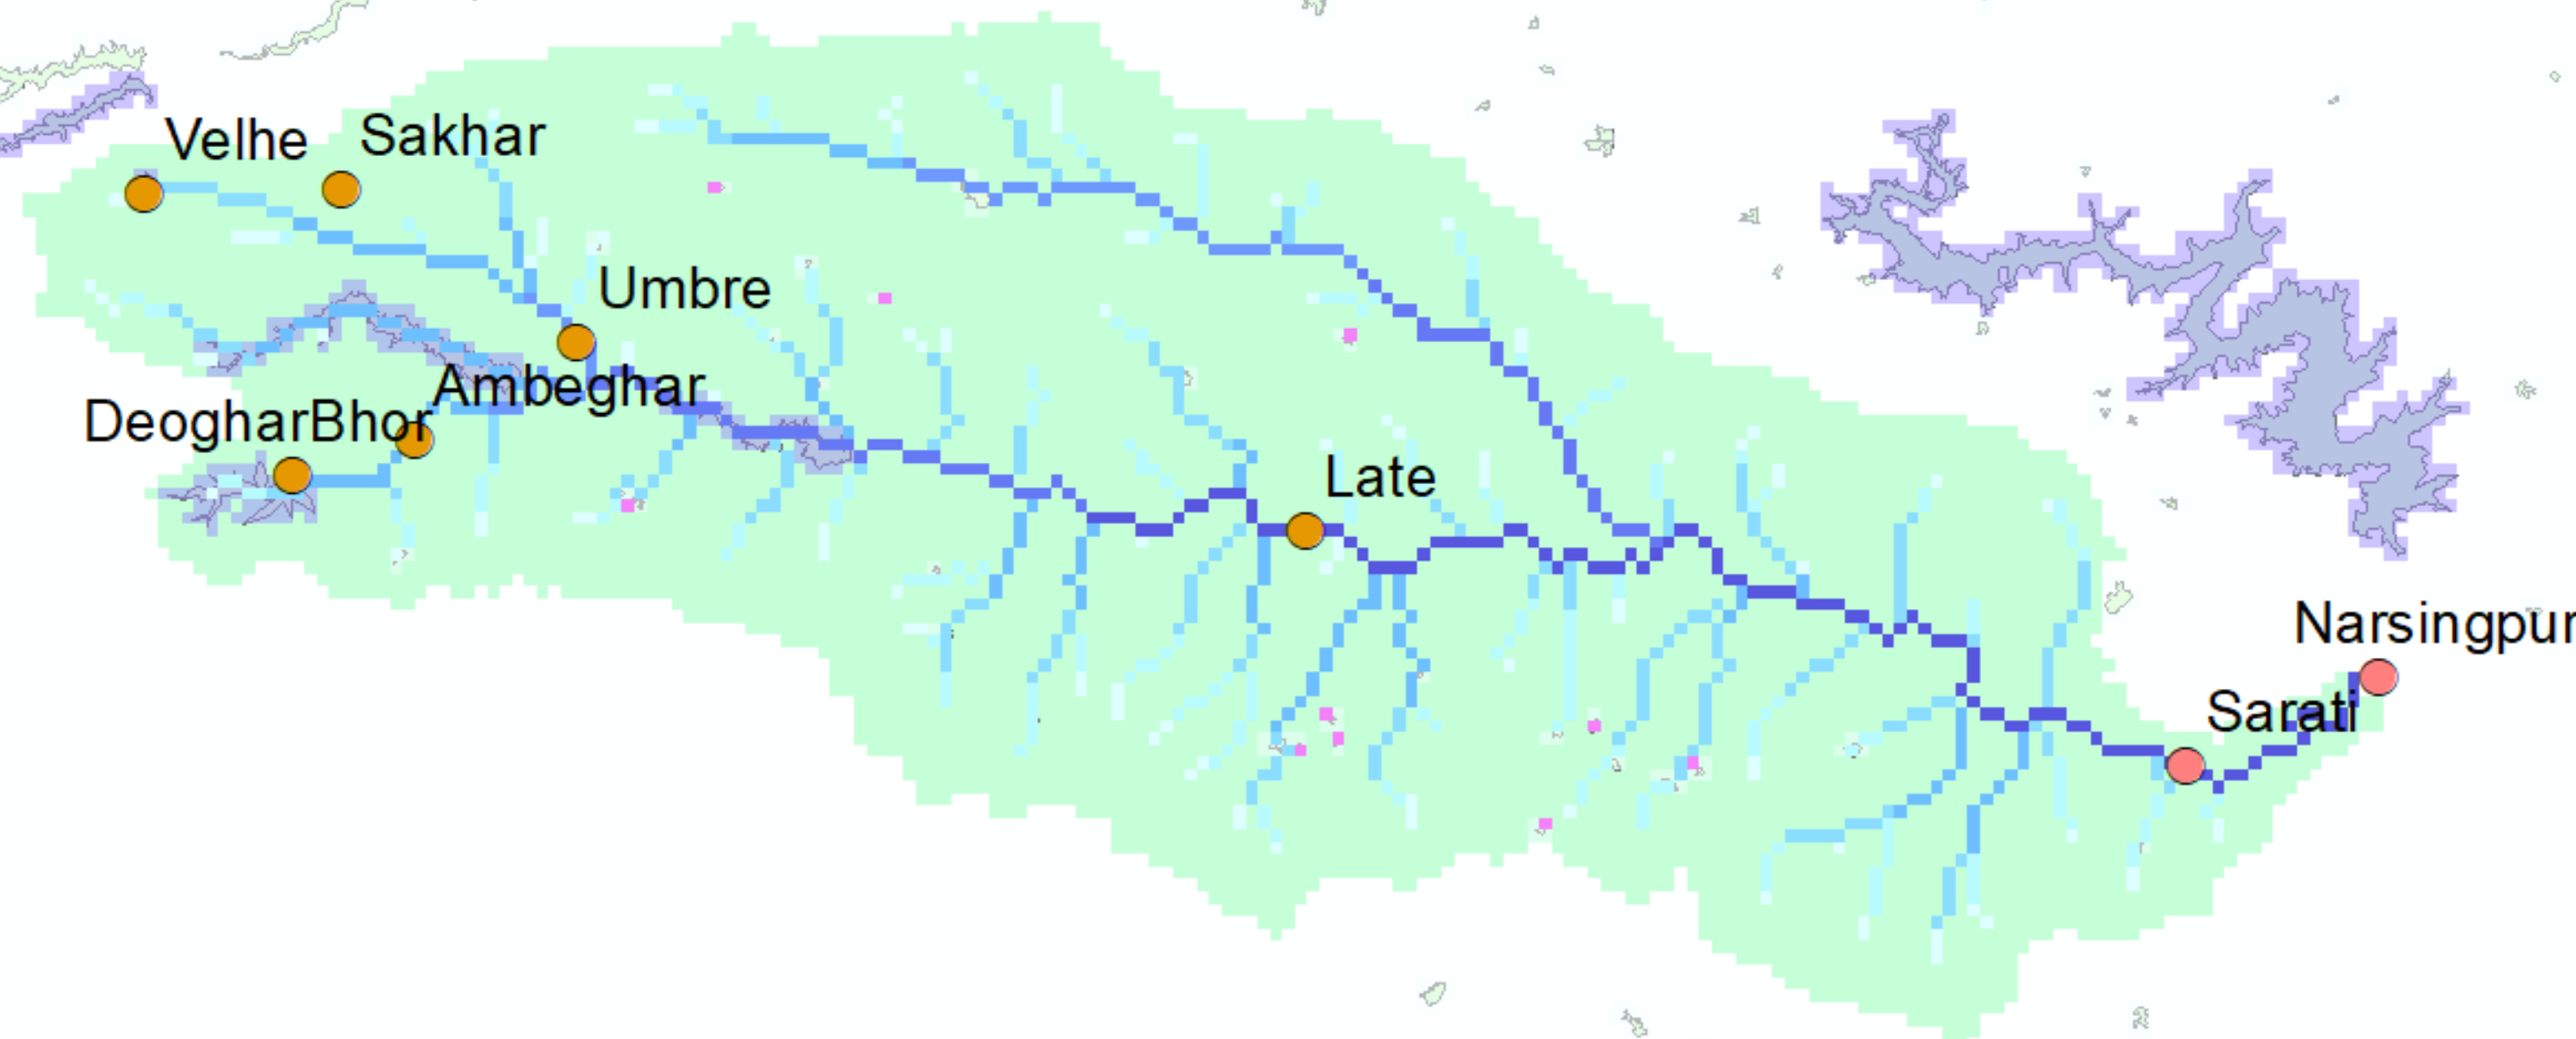

In [3]:
#Genereally from downstream to upstream

Discharge_Sarati = [('Sarati', 17.911, 75.005, 1), 
                    ('Late', 18.0717, 74.407, 1), 
                    ('Umbre',18.2, 73.911, 1), 
                    ('Ambeghar', 18.133, 73.795, 1), 
                    ('Velhe', 18.3008, 73.6167, 1),
                    ('Sakhar', 18.30417, 73.6625, 1),
                    #('Sakhar', 18.27083, 73.75417),
                    #('Sakhar', 18.304, 73.75),
                    ('DeogharBhor', 18.104, 73.73, 1./10)]

os.listdir(photo_folder)

img = Image.open(photo_folder + '/dischargeGaugingLocations_onSarati_withFlowAccumulation.png')
img

 - Sakhar and DeogharBhor may need adjusting and are not included. 
 - Narsingpur is in fact out of the sub-basin, at the confluence of the Nira and Bhima basins.

Notes on correcting/adapting the observational lat/lon over the ldd (local drain direction) cellular strucutre: 

The following CWC river discharge locations have been edited: 

-Locations for Sakhar and Ambaghar may be incorrect

-Sakhar
 - Current: Original
 - ('Sakhar', 18.304, 73.75)  Original
 - ('Sakhar', 18.29, 73.72) slightly downstream and western. Measured values are larger. 
 - ('Sakhar', 18.2555, 73.815) eastern and further downstream at the confluence. Simulated values are larger. 

-DeogharBhor
 - Current: ('DeogharBhor', 18.104, 73.73) downstream, after the reservoir. 
 - ('DeogharBhor', 18.108, 73.7167) Original. Measured values are larger. 


In [4]:
# The discharge data 1960-2010 is held here, where each reservoir timeseries is named after itself, such as, 'Veer.xlsx' 
observed_discharge_folder = measuredData_folder + '/River water level and discharge_Historical/Discharge_Sarati'

#This is in the CWatM Output folder
simulated_discharge = output_folder + '/discharge_daily.nc'





## Processing

In [5]:
def geo_idx(dd, dd_array):
   """
     search for nearest decimal degree in an array of decimal degrees and return the index.
     np.argmin returns the indices of minium value along an axis.
     so subtract dd from all values in dd_array, take absolute value and find index of minium.
    """
   geo_idx = (np.abs(dd_array - dd)).argmin()
   return geo_idx

## Simulated discharge

In [6]:
nc_simulated = Dataset(simulated_discharge, 'r')

Dates_simulated = num2date(nc_simulated.variables['time'][:], units=nc_simulated.variables['time'].units)
#Dates_simulated2 = num2date(nc_simulated.variables['time'][:], units=nc_simulated.variables['time'].units, only_use_cftime_datetimes=False,)
#print(Dates_simulated2)
FLOWS_simulated = []

lats = nc_simulated.variables['lat'][:]
lons = nc_simulated.variables['lon'][:]

for discharge_location in Discharge_Sarati:
    in_lat = discharge_location[1]
    in_lon = discharge_location[2]
    
    lat_idx = geo_idx(in_lat, lats)
    lon_idx = geo_idx(in_lon, lons)
    
    FLOWS_simulated.append(nc_simulated.variables['discharge'][:, lat_idx, lon_idx])
    

## Observed discharge

In [7]:
DATES_observed = []
FLOWS_observed = []
FLOWSADJ_observed = []

observed_folder_list = os.listdir(observed_discharge_folder)

for discharge_location in Discharge_Sarati:

    print(discharge_location[0])
    if discharge_location[0] +'.xlsx' in observed_folder_list:
        book = xlrd.open_workbook(observed_discharge_folder +'/'+ discharge_location[0] +'.xlsx')
        sheet = book.sheet_by_index(0)
        num_rows = sheet.nrows

        _Dates_observed = [xlrd.xldate_as_tuple(int(sheet.cell(row,0).value), 0) for row in range(2, num_rows)]
        Dates_observed = [datetime.datetime(d[0], d[1], d[2]) for d in _Dates_observed]

        Flows_observed = [sheet.cell(row, 1).value for row in range(2, num_rows)]
        
        """
        for i in Flows_observed:
            print('i', i)
            print('i==blank', i=="")
            print('i*.1', i*.1)
            print('discharge_location[0]', discharge_location[0])
            print('discharge_location[3]', discharge_location[3])
            print('i*discharge_location[3]',i*discharge_location[3])
        """
        
        Flows_observed_adjusted = [i*discharge_location[3] if i!='' else '' for i in Flows_observed]
        FLOWSADJ_observed.append(Flows_observed_adjusted)
        
        DATES_observed.append(Dates_observed)
        FLOWS_observed.append(Flows_observed)
        
    else:
        print('missing ' + discharge_location[0])
        DATES_observed.append([])
        FLOWS_observed.append([])
        FLOWSADJ_observed.append([])
        

Sarati
Late
Umbre
Ambeghar
Velhe
Sakhar
DeogharBhor


## Visualisation 

In [11]:
for i in range(len(Discharge_Sarati)):

    fig = go.Figure()

    fig.add_trace(go.Scatter(y=FLOWS_simulated[i],
                             x=Dates_simulated,
                    mode='lines',
                    name='Simulated',
                            line=dict(color='#EF5538', width=1)))


    fig.add_trace(go.Scatter(y=FLOWS_observed[i],
                             x=DATES_observed[i],
                    mode='lines',
                    name='Observed',
                            opacity=0.9, 
                             line=dict(color='#636EFA', width=1)))
    
    if Discharge_Sarati[i][3]!=1:
        
        fig.add_trace(go.Scatter(y=FLOWSADJ_observed[i],
                         x=DATES_observed[i],
                mode='lines',
                name='Observed'))
        
 

    fig.update_layout(title='Discharge: '+ Discharge_Sarati[i][0],
                           xaxis_title='Days',
                           yaxis_title='Discharge (m3/s)')
    fig.update_layout(legend_orientation="h")

    fig.show()